# Volatility Capital: Quantitative Trading Strategy Final Project

- Aryamaan Jena - 12334126
- William Labasi-Sammartino - 12332761
- Som Mookherji - 12334609

## Introduction and Strategy Overview

We propose a volatility trading strategy where we trade call and put options on 11 microchip equities (AMD, AVGO, INTC, MCHP, MPWR, MU, NVDA, NXPI, QCOM, SWKS, and TXN) from 2018-01-01 to 2019-12-31.

The trading strategy relies on constructing volatility cones using predicted volatilities from an ensemble of Machine Learning algorithms. Once these cones are in hand, we can proceed with the trading strategy. We consider opening options in the equity options every Wednesday. On each of these investment days, we observe the spot implied volatility (IV) (EOD from Option Metrics) of ATM options. We subsequently compare this spot IV to the boundaries of the volatilty. If it is above the "high boundary" or below the "low boundary" we continue. 

We then look at our forecast of the realized volatility of whatever time will be left before the options expire in 30 days. If this realized volatility is within the volatility cone, then we open the position in the appropriate fashion. More precisely, if the volatility forecast ($\hat{\sigma}$) is less than the spot IV ($\sigma_{IV}$), then short the options. If the relationship is the other way around, we go long the options. The sell date -- barring any stop loss -- is at the moment of the forecast i.e. in 30 days. For each investment day, we do this for every option-equity this means that we may have several option candidates for one particular equity for a given investment day. We calculate the expected PnL to determine the option's attractiveness like this:

$$PnL = |vega*(\hat{\sigma} - \sigma_{IV})| \;\;\;\;\;\;\; (1)$$

We only keep the option with the highest PnL per equity. This means that for a given investment day, we may at most open 11 option positions.


Key backtesting features:
- Portfolio Allocation : We consider two schemes: 1/N and a weighted scheme. The 1/N scheme is exactly as what it sounds like: it allocates 1/N of the deployed capital for each option position. The weighted scheme allocates the deployed capital according to the following weights: $PnL_i / \sum_i PnL_i$. Effectively, options that have a higher PnL will get more capital than those that have less projected PnL.
- Stop Loss and Risk Management: All option positions are delta hedged at the moment of their opening. We do this since we are agnostic on the underlying stocks. These delta hedges are rebalanced on a weekly basis. We also include stop loss mechanism where, on a daily basis, we compare the spot $\sigma_{IV}$ to the $\sigma_{IV}$ that had originally generated the trading signal. If the $\sigma_{IV}$ moves more than X% in the wrong direction, we immediately close the position. This only has to occur on one of the options of the set that was opened on a particular day. The reasoning behind this mechanism is that the volatilities of these 11 stocks are likely correlated with each other. Therefore, if one prediction is off track, it may very well be possible that the other ones are as well. In our backtest we also look at maximum drawdown and measures like the Sharpe Ratio which take into account the volatility of the returns.
- Transaction Costs & Liquidity: Transactions costs and liquidity is factored in through the price that is payed on the options and the stock. For the option transactions, we have the best bid and best ask for each day. We assume that most of the transacions will be done passively (at the mid) but we introduce a simple skew. Effectively, the price is: $Mid \pm ((1/2) + (1/200)*\sqrt{quantity})|(bid-ask)|$, depending on if we are shorting or going long on the option. We do something similar for equities except with caveat that we do not have the bid-ask data. Instead we just add a cost to the price: $price + (1/10) + (1/1000)\sqrt(quantity)$.
- Leverage: We also introduce the possibility of leveraging only the options positions. That is, the delta hedge only protects our capital -- not what is borrowed -- from changes in the underlying. We assume a simple fixed borrowing cost of 2%.
- Capacity: We follow a simple dollar cost averaging scheme where each week, on the investment day where we open positions, we open \$1,000 worth of option positions. The fact that options are sold in lots of 100 is implemented in the backetest. This is however different for the delta hedge; since equity markets are more liquid and accessible, we assume we can easily buy and sell fractional shares of stock. All additional costs that do not relate to the options purchase are added as "cost." We assume that we delta hedge as needed i.e. there is no capital constraint on the purchase and sale of stock.


In [450]:
# If you want to make the cells wider, run this
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [474]:
# importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from itertools import product
import scipy as sp
from scipy.interpolate import interp1d

import seaborn as sns

from datetime import datetime


import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from plotnine import *
from plotnine.data import *

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# import pandas_datareader
import quandl
import pickle

import functools
import datetime as dt
from datetime import datetime, timedelta
import warnings

import plotly.express as px
# import kaleido

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import arch
from sklearn.linear_model import LinearRegression

# configuring
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 65
pd.set_option('use_inf_as_na', True)

sns.set()
color = sns.color_palette()
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

def plot_cones(cone_data, interp_cone_data, ticker, w):
    """
    cone_data: df that contains cone boundary points
    interp_cone_data: df that contains interpolated cone boundary points
    ticker: ticker whose cone data is being plotted
    w: weighting used to build cones {mean, exponential}
    """
    palette = sns.color_palette("flare", 10)
    my_cmap = ListedColormap(palette.as_hex())
    
    fig, ax = plt.subplots()

    ax.scatter(cone_data['days_to_expiry'], cone_data['cone'], c=cone_data['rank'], 
               cmap = my_cmap, alpha=1)

    for rank in range(1,11):
        x = [i for i in range(10,92)]
        y = interp_cone_data[interp_cone_data['rank'] == rank]['interp_cone'].to_list()
        ax.plot(x, y, c=palette[rank-1], alpha=0.7, label=f'Rank {rank}')

    ax.legend()
    plt.title(f'Volatility Cones - Ticker: {ticker}, Weighting: {w}')   
    plt.xlabel('Days to Expiry')
    plt.ylabel('Volatility Splines')
    plt.legend()
    plt.show()
    
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

        
def plot_histogram(df, var, title): 
    plot = (ggplot(data = df, 
               mapping = aes(x = var)) +
             geom_histogram(colour = "black", fill = "white") +
     # 25% quantile
      geom_vline(aes(xintercept=df[var].quantile(.25)),
                color="blue", linetype="dashed", size=1) +
     # median
     geom_vline(aes(xintercept=df[var].quantile(.5)),
                color="blue", linetype="dashed", size=1)+
     # mean
     geom_vline(aes(xintercept=df[var].mean()),
                color="red", linetype="dashed", size=1)+
      # 75% quantile
      geom_vline(aes(xintercept=df[var].quantile(.75)),
                color="blue", linetype="dashed", size=1) +
     theme(element_text(angle = 90, vjust = 0.5, hjust=1)) +
     ggtitle(title)
    )
    
    print(plot)

In [3]:
# Import Cones Data

cones_data_groups = {}
cones_data_groups["AMD_interp_exp_cones"] = AMD_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AMD_interp_mean_cones"] = AMD_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["AMD_realized_exp_cones"] = AMD_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AMD_realized_mean_cones"] = AMD_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_interp_exp_cones"] = AVGO_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_interp_mean_cones"] = AVGO_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_realized_exp_cones"] = AVGO_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_realized_mean_cones"] = AVGO_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_interp_exp_cones"] = INTC_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_interp_mean_cones"] = INTC_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_realized_exp_cones"] = INTC_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_realized_mean_cones"] = INTC_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_interp_exp_cones"] = MCHP_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_interp_mean_cones"] = MCHP_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_realized_exp_cones"] = MCHP_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_realized_mean_cones"] = MCHP_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_interp_exp_cones"] = MPWR_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_interp_mean_cones"] = MPWR_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_realized_exp_cones"] = MPWR_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_realized_mean_cones"] = MPWR_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MU_interp_exp_cones"] = MU_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MU_interp_mean_cones"] = MU_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MU_realized_exp_cones"] = MU_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MU_realized_mean_cones"] = MU_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_interp_exp_cones"] = NVDA_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_interp_mean_cones"] = NVDA_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_realized_exp_cones"] = NVDA_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_realized_mean_cones"] = NVDA_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_interp_exp_cones"] = NXPI_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_interp_mean_cones"] = NXPI_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_realized_exp_cones"] = NXPI_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_realized_mean_cones"] = NXPI_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_interp_exp_cones"] = QCOM_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_interp_mean_cones"] = QCOM_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_realized_exp_cones"] = QCOM_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_realized_mean_cones"] = QCOM_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_interp_exp_cones"] = SWKS_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_interp_mean_cones"] = SWKS_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_realized_exp_cones"] = SWKS_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_realized_mean_cones"] = SWKS_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_interp_exp_cones"] = TXN_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_interp_mean_cones"] = TXN_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_realized_exp_cones"] = TXN_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_realized_mean_cones"] = TXN_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_realized_mean_cones.csv").iloc[: , 1:]


In [4]:
# Get Fama French factor returns
fama_french = pd.read_csv("/Users/williamsammartino/Desktop/F-F_Research_Data_Factors.CSV",\
                         header = 2)

# Needs to be formated
fama_french.rename(columns={ fama_french.columns[0]: "date" }, inplace = True)

fama_french = fama_french.iloc[1000:1145,]

fama_french["year"] = pd.to_numeric(fama_french.iloc[:, 0].str[:4])
fama_french["month"] = pd.to_numeric(fama_french.iloc[:, 0].str[4:7])

fama_french["Mkt-RF"] = pd.to_numeric(fama_french["Mkt-RF"]) / 100
fama_french["SMB"] = pd.to_numeric(fama_french["SMB"]) / 100
fama_french["HML"] = pd.to_numeric(fama_french["HML"]) / 100
fama_french["RF"] = pd.to_numeric(fama_french["RF"]) / 100

fama_french.set_index(['year', 'month'], inplace = True)

In [5]:
# Import realized volatility forecasts
pred_realized_vol = pd.read_csv("/Users/williamsammartino/Desktop/backtest_pred_realized_vol.csv")
pred_realized_vol["date"] = pred_realized_vol["date"].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

# Import options data 
options_data = pd.read_csv("/Users/williamsammartino/Desktop/options_prices_microchips.csv")

In [6]:
# Import stock price data (underlyings)
stock = pd.read_csv("/Users/williamsammartino/Desktop/microchip_stocks.csv")

In [7]:
stock["date_raw"] = stock["date"]
stock["date"] = stock["date"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [8]:
options_data["date_raw"] = options_data["date"]
# options_data["date"] = options_data["date"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
options_data["date"] = pd.to_datetime(options_data["date_raw"].astype("str"))
# options_data["expiry_date"] = options_data["exdate"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
options_data["expiry_date"] = pd.to_datetime(options_data["exdate"].astype("str"))
options_data = options_data[options_data["date"]>="2017-12-01"]
options_data["strike"] = options_data["strike_price"] / 1000 

In [9]:
options_data_groups = {}
groups = ["AMD", "AVGO", "INTC", "MCHP", "MPWR", "MU", "NVDA", "NXPI", "QCOM", "SWKS", "TXN"]
for grp in groups:
    options_data_groups[grp] = options_data[options_data["ticker"] == grp].copy()

In [398]:
# Functions for strategy ###########################################################
####################################################################################

# THIS FUNCTION GETS OPTION CANDIDATES FOR EACH STOCK

stock_of_interest = "AMD"
cone_type = "_interp_mean_cones"
date_of_interest = "2018-1-10"
days_ahead_forecast = 10
high_rank = 6
low_rank = 4

def get_candidates(stock_of_interest, date_of_interest, days_ahead_forecast, cone_type, high_rank, low_rank) :
    

    # Get spot stock price
    spot_stock_price = stock[(stock["TICKER"] == stock_of_interest) & 
                 (stock["date"] == date_of_interest)]["PRC"].values
    
    # Get spot IV of ATM options
    ############################################
    options_table = options_data_groups[stock_of_interest]
    options_table["days_to_expiry"] = (options_table["expiry_date"] - dt.datetime.strptime(date_of_interest, '%Y-%m-%d')).dt.days
    options_table = options_table[options_data["date"] == date_of_interest]
    options_table["moneyness"] = abs(options_table["strike"] - spot_stock_price)
    options_table = options_table[options_table["moneyness"] == options_table["moneyness"].min()][['ticker', 'optionid','cp_flag','days_to_expiry', 'strike', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta']]
    options_table = options_table[options_table["days_to_expiry"] > (days_ahead_forecast + 1)] # Options need to have enough time left for forecast.
    
    
    # Join to Cone to make comparison
    cones_table = cones_data_groups[stock_of_interest + cone_type]
    options_table = options_table.merge(cones_table[(cones_table["rank"] == high_rank) | (cones_table["rank"] == low_rank)],\
                        on='days_to_expiry', how='left').dropna()
    

    
    options_table["oob"] = np.where(
        ((options_table["rank"] == low_rank) & \
        (options_table["impl_volatility"] < options_table["interp_cone"])) | 
        ((options_table["rank"] == high_rank) & \
        (options_table["impl_volatility"] > options_table["interp_cone"])), True, False)
    
    options_table = options_table[options_table["oob"] == True]
    

    # Check Forecast 
    sell_dates = []
    forecast = np.empty(len(options_table))
    forecast_time = np.empty(len(options_table))
    gap_tolerance = 10
    for i in range(0, len(options_table)):
        reference_real_vol_time = min([10, 30, 60, 91], key=lambda x:abs(x-(options_table["days_to_expiry"].iloc[i] - days_ahead_forecast))) # Gets vol time of whatever is left of the option in the future.
        reference_real_vol = pred_realized_vol[pred_realized_vol["date"] ==
                      max(date for date in safe_dates["date"] if date <= (dt.datetime.strptime(date_of_interest, '%Y-%m-%d') + dt.timedelta(days=int(days_ahead_forecast))))][str(reference_real_vol_time) + "_" + stock_of_interest]
        sell_date = max(date for date in safe_dates["date"] if date <= (dt.datetime.strptime(date_of_interest, '%Y-%m-%d') + dt.timedelta(days=int(days_ahead_forecast))))
        gap = abs(reference_real_vol_time - (options_table["days_to_expiry"].iloc[i] - days_ahead_forecast))
        
        cone_upper_bound = cones_table[(cones_table["days_to_expiry"] == reference_real_vol_time) & (cones_table["rank"] == high_rank)]["interp_cone"]
        cone_lower_bound = cones_table[(cones_table["days_to_expiry"] == reference_real_vol_time) & (cones_table["rank"] == low_rank)]["interp_cone"]
        
        if (gap <= gap_tolerance) & (options_table["rank"].iloc[i] == high_rank) & (float(reference_real_vol) < float(cone_upper_bound)):
                forecast_time[i] = reference_real_vol_time
                forecast[i] = reference_real_vol
                sell_dates.append(sell_date)
        elif (gap <= gap_tolerance) & (options_table["rank"].iloc[i] == low_rank) & (float(reference_real_vol) > float(cone_lower_bound)):
                forecast_time[i] = reference_real_vol_time
                forecast[i] = reference_real_vol
                sell_dates.append(sell_date)
        else:
            forecast_time[i] = float('nan')
            forecast[i] = float('nan')
            sell_dates.append(np.nan)
    

    options_table["sell_date"] = np.array(sell_dates)
    options_table["forecast_days_to_expiry"] = forecast_time
    options_table["forecast"] = forecast
    
    options_table = options_table.dropna()
    
    # Calculate PnL estimate for each option
    options_table["pnl_estimate"] = abs(options_table["vega"]*(options_table["forecast"] - options_table["impl_volatility"]))
    
        
    # Keep only highest PnL
    options_table = options_table[options_table["pnl_estimate"] ==options_table["pnl_estimate"].max()].head(1).copy()
    
    # Add option price
    options_table["price"] = (options_table["best_bid"] + options_table["best_offer"]) /2 
    
    candidates = options_table.copy()
    

    return candidates

# Get spot option info function

def get_spot_option(df):

    tickers = df["ticker"]
    optionsids = df["optionid"]
    
    # build updated options dataset
    options_table_updated = []
    for ticker, optionid in zip(tickers, optionsids):
        options_table_updated.append(
            options_data_groups[ticker][(options_data_groups[ticker]["date"] == dt.datetime.strptime(spot_date, '%Y-%m-%d')) & (options_data_groups[ticker]["optionid"] == int(optionid))]
        )
        
    options_table_updated = pd.concat(options_table_updated).copy()
      
    return options_table_updated

# Open Position Function
def open_positions(deployed_capital, spot_date, days_ahead_forecast, high_rank, low_rank, weighting = "weighted"):
    

    candidates_of_the_day = []
    for ticker in list_of_tickers:
        candidates_of_the_day.append(get_candidates(stock_of_interest = ticker,
                cone_type = "_interp_mean_cones",
                date_of_interest = spot_date,
                days_ahead_forecast = days_ahead_forecast,
                high_rank = high_rank,
                low_rank = low_rank))
    candidates_of_the_day = pd.concat(candidates_of_the_day)    
    
    # Add weights (portfolio allocation)
    candidates_of_the_day["portfolio_weight"] = candidates_of_the_day["pnl_estimate"] / sum(candidates_of_the_day["pnl_estimate"])
    
    # Open option positions
    candidates_of_the_day["position_type"] = np.where(candidates_of_the_day["rank"] == high_rank, "short",
                                                 np.where(candidates_of_the_day["rank"] == low_rank, "long", "ERROR"))
    if weighting == "weighted":
        candidates_of_the_day["quantity"] = np.where(candidates_of_the_day["position_type"] == "short", np.round((deployed_capital * candidates_of_the_day["portfolio_weight"] * -1)/100) * 100,
                                                 np.where(candidates_of_the_day["position_type"] == "long", np.round((deployed_capital * candidates_of_the_day["portfolio_weight"])/100) * 100, np.nan)
                                                )
    elif weighting == "1/N" and len(candidates_of_the_day) != 0:
        candidates_of_the_day["quantity"] = np.where(candidates_of_the_day["position_type"] == "short", np.round((deployed_capital * (1 / len(candidates_of_the_day)) * -1)/100) * 100,
                                                 np.where(candidates_of_the_day["position_type"] == "long", np.round((deployed_capital * (1 / len(candidates_of_the_day)))/100) * 100, np.nan)
                                                )
    elif weighting == "1/N" and len(candidates_of_the_day) == 0:
        candidates_of_the_day["quantity"] = np.round((deployed_capital * (1 / 2))/100) * 100 # put whatever, no effect as there are no candidates
        
    
#     candidates_of_the_day["notional"] = candidates_of_the_day["quantity"] * candidates_of_the_day["price"]
    candidates_of_the_day["notional"] = np.where(candidates_of_the_day["position_type"] == "short", candidates_of_the_day["quantity"] * (candidates_of_the_day["price"] + ((1/200) * np.sqrt(abs(candidates_of_the_day["quantity"])) + 0.05) * (candidates_of_the_day["price"] - candidates_of_the_day["best_bid"])),
                                                 np.where(candidates_of_the_day["position_type"] == "long", candidates_of_the_day["quantity"] * (candidates_of_the_day["price"] + ((1/200) * np.sqrt(abs(candidates_of_the_day["quantity"])) + 0.05) * (candidates_of_the_day["best_offer"] - candidates_of_the_day["price"])), np.nan)
                                                )
    
    candidates_of_the_day["buy_date"] = spot_date
    candidates_of_the_day["buy_date"] = candidates_of_the_day["buy_date"].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
    candidates_of_the_day = candidates_of_the_day.reset_index(drop = True)
    
    # Delta Hedge
    
    candidates_of_the_day["quantity_hedge"] = np.where(
                                                 (candidates_of_the_day["position_type"] == "short") & (candidates_of_the_day["cp_flag"] == "P"),  abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]) * -1,  
        
                                              np.where(
                                                 (candidates_of_the_day["position_type"] == "short") & (candidates_of_the_day["cp_flag"] == "C"),  abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]),
                                              
                                              np.where(
                                                 (candidates_of_the_day["position_type"] == "long") & (candidates_of_the_day["cp_flag"] == "P"),  abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]) ,         
                                                       
                                              np.where(
                                                 (candidates_of_the_day["position_type"] == "long") & (candidates_of_the_day["cp_flag"] == "C"), abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]) * -1,
                                                  
                                                  np.nan))))
    
    candidates_of_the_day = candidates_of_the_day.merge(stock.rename(columns={"TICKER": "ticker", "date": "buy_date"})[["buy_date", "ticker", "PRC"]],\
                            on=['buy_date', 'ticker'], how='left')
    
    candidates_of_the_day["notional_hedge"] = np.where(candidates_of_the_day["quantity_hedge"] <= 0, candidates_of_the_day["quantity_hedge"] * (candidates_of_the_day["PRC"] - candidates_of_the_day["PRC"] * ((1/1000) * np.sqrt(abs(candidates_of_the_day["quantity_hedge"])) + 0.01)),
                                                       np.where(candidates_of_the_day["quantity_hedge"] > 0, candidates_of_the_day["quantity_hedge"] * (candidates_of_the_day["PRC"] + candidates_of_the_day["PRC"] * ((1/1000) * np.sqrt(abs(candidates_of_the_day["quantity_hedge"])) + 0.01)),
                                                               0))
    
    total_investment = np.nansum(abs(candidates_of_the_day["notional"])) + np.nansum(abs(candidates_of_the_day["notional_hedge"]))
    

    return([candidates_of_the_day, total_investment])


# Close positions function

def close_positions(df, spot_date, leverage_ratio, stop_loss_threshold):
    
    # Only check stop losses of open positions
    stop_loss = False
    
    if all(df.columns != "date_closed"):
        df_check = df.copy()
        df_check["spot_IV"] = np.array(get_spot_option(df)['impl_volatility'])
        df_check['vol_distance'] = (df_check['spot_IV'] - df_check['impl_volatility']) / df_check['impl_volatility']
        df_check["stop_losses_check"] = np.where((df_check["quantity"] < 0) & (df_check["vol_distance"] > stop_loss_threshold), "stop losses",
            np.where((df_check["quantity"] > 0) & (df_check["vol_distance"] < (-1 * stop_loss_threshold)), "stop losses", "OK"))
        
        if any(df_check["stop_losses_check"] == "stop losses"):
            stop_loss = True
        
     
    if (all(df["sell_date"] == dt.datetime.strptime(spot_date, '%Y-%m-%d')) | (stop_loss == True)) & (all(df.columns != "date_closed")):
        
        # Start with getting spot options price
        updated_options_table = get_spot_option(df)
        updated_options_table["updated_price"] = (updated_options_table["best_bid"] + updated_options_table["best_offer"]) /2 
        
    
        df_updated = df.merge(updated_options_table[["ticker", "updated_price"]],\
                                on=['ticker'], how='left')
        
    
        # Get spot stock price
        df_updated = df_updated.merge(stock[stock["date"] == spot_date].rename(columns={"TICKER": "ticker", "PRC" : "updated_PRC"})[["ticker", "updated_PRC"]],\
                                on=['ticker'], how='left')
        
        # Calculate options PnL after closing position.
        df_updated["options_pnl"] = np.where(df_updated["position_type"] == "short",  df_updated["quantity"] * df_updated["updated_price"] - df_updated["notional"],
                                     np.where(
                                                     df_updated["position_type"] == "long", df_updated["quantity"] * df_updated["updated_price"] - df_updated["notional"], np.nan
                                                  ))
        # Calculate delta hedge PnL after closing position.
        df_updated["hedge_pnl"] = df_updated["quantity_hedge"] * df_updated["updated_PRC"] - df_updated["notional_hedge"]
        
        # tally everything up
        df_updated["date_closed"] = spot_date
        total_pnl =  (1 * leverage_ratio) * df_updated["options_pnl"].sum() + df_updated["hedge_pnl"].sum() - leverage_ratio * 1.02 * sum(abs(df_updated["quantity"]))
        total_notional = sum(abs(df_updated["notional"]) + abs(df_updated["notional_hedge"]))
    
    else:
        df_updated = df.copy()
        total_pnl = np.nan
        total_notional = np.nan
    

    
    return([df_updated, total_pnl, total_notional, stop_loss])


# Rebalancing function
def rebalance(df, spot_date):
    if 'hedge_pnl' not in df.columns:
#         print("rebalance")
        
        updated_options = get_spot_option(df)[["ticker", "delta"]]
        
        df_updated = df.drop(columns = ["delta", "PRC"]).copy()
        
        df_updated = df_updated.merge(updated_options,\
                                    on=['ticker'], how='left')
            
        
        # Get spot stock price
        stock_subset = stock[stock["date"] == dt.datetime.strptime(spot_date, '%Y-%m-%d')][["TICKER", "PRC"]]
        df_updated = df_updated.merge(stock_subset.rename(columns={"TICKER": "ticker" }),\
                                    on=['ticker'], how='left')
        
        # Rebalance
        
        df_updated["target_quantity_hedge"] = np.where(
                                                     (df_updated["position_type"] == "short") & (df_updated["cp_flag"] == "P"),  abs(df_updated["delta"] * df_updated["quantity"]) * -1,  
            
                                                  np.where(
                                                     (df_updated["position_type"] == "short") & (df_updated["cp_flag"] == "C"),  abs(df_updated["delta"] * df_updated["quantity"]),
                                                  
                                                  np.where(
                                                     (df_updated["position_type"] == "long") & (df_updated["cp_flag"] == "P"),  abs(df_updated["delta"] * df_updated["quantity"]) ,         
                                                           
                                                  np.where(
                                                     (df_updated["position_type"] == "long") & (df_updated["cp_flag"] == "C"), abs(df_updated["delta"] * df_updated["quantity"]) * -1,
                                                      
                                                      np.nan))))
        
        df_updated["target_notional_hedge"] = df_updated["notional_hedge"] + (df_updated["target_quantity_hedge"] - df_updated["quantity_hedge"])* df_updated["PRC"]
        
        # PnL from rebalancing
        df_updated["investment_to_rebalance"] = (abs(df_updated["target_quantity_hedge"]) - abs(df_updated["quantity_hedge"])) * df_updated["PRC"]
        
        
        total_investment = df_updated["investment_to_rebalance"][df_updated["investment_to_rebalance"] > 0].sum()
        
    #     total_profit = df_updated["notional_hedge"][df_updated["investment_to_rebalance"] < 0] / df_updated["quantity_hedge"][df_updated["investment_to_rebalance"] < 0]
        
        # fix df so it can go back in portfolio
        
        df_updated = df_updated.drop(columns = ["quantity_hedge", "notional_hedge", 'investment_to_rebalance']).copy()
        df_updated = df_updated.rename(columns={"target_notional_hedge": "notional_hedge", "target_quantity_hedge" : "quantity_hedge"}).copy()
        df_updated["last_rebalance"] = spot_date
    
    else:
        df_updated = df.copy()
        total_investment = 0
    
    return([df_updated, total_investment])
    

In [304]:
# LOOP THGROUGH TIME TO BACKTEST STRATEGY
list_of_tickers = ["AMD","AVGO","INTC","MCHP","MPWR","MU","NVDA","NXPI","QCOM","SWKS","TXN"]

# Safe dates
safe_dates = pd.Series(list(set(options_data["date"]) & set(pred_realized_vol["date"]) & set(stock["date"])))
frame = {'date': safe_dates.sort_values()}
safe_dates = pd.DataFrame(frame)
safe_dates = safe_dates.reset_index(drop = True)
safe_dates["week"] = safe_dates["date"].dt.dayofweek
safe_dates = safe_dates[safe_dates["date"] <= "2019-12-31"]

In [330]:
# On investment days and rebalancing the delta hedge. 
high_rank = 10
low_rank = 1
days_ahead_forecast = 30
cone_type = "_interp_mean_cones"
weighting = "weighted"
leverage_ratio = 10
stop_loss_threshold = 0.10

In [434]:
def vol_cone_strategy(high_rank, low_rank, days_ahead_forecast, cone_type, weighting, leverage_ratio, stop_loss_threshold):

    high_rank = high_rank
    low_rank = low_rank
    days_ahead_forecast = days_ahead_forecast
    cone_type = cone_type
    weighting = weighting
    leverage_ratio = leverage_ratio
    stop_loss_threshold = stop_loss_threshold
    
    overall_accounting = []
    portfolio = []
    
    stop_loss_count = 0
    for i in range(0, len(safe_dates)):
    # for i in range(0, 11):
        
    
        if i % 1 == 0: 
            print('i = {}'.format(i))
            print(safe_dates["date"].iloc[i])
        
    
        # Close positions // stop loss only on investment days
        if not portfolio:
            total_pnl_from_closing = np.nan
            total_notional_from_closing = np.nan
        else:
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            total_notional_from_closing = []
            pnl = []
            stop_loss_meter = []
            for j in range(0, len(portfolio)):
                closed_positions_list = close_positions(df = portfolio[j], spot_date = spot_date, leverage_ratio=leverage_ratio, stop_loss_threshold = stop_loss_threshold)
                portfolio[j] = closed_positions_list[0].copy()
                pnl.append(closed_positions_list[1])
                total_notional_from_closing.append(closed_positions_list[2])
                stop_loss_meter.append(closed_positions_list[3])
            
            total_pnl_from_closing = np.nansum(pnl) # PnL from closing position
            total_notional_from_closing = np.nansum(total_notional_from_closing) # Total notional from closing
            stop_loss_count = stop_loss_count + sum(stop_loss_meter)
            
       
    
        
        # Open positions on investment days
        if (safe_dates["week"].iloc[i] == 2) & (i <= (len(safe_dates) - days_ahead_forecast - 5)): 
    #         print("rebalancing")
            
             # Rebalance
            if not portfolio:
                total_investment_from_opening_positions = np.nan
            else:
                spot_date = safe_dates["date"].iloc[i]
                spot_date = spot_date.strftime('%Y-%m-%d')
                for j in range(0, len(portfolio)):
                    portfolio[j] = rebalance(df = portfolio[j], spot_date = spot_date)[0].copy()
            
            
            
            
    #         print("investing")
            # If investment day, open positions
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            
            candidates_of_the_day = open_positions(deployed_capital = 1000,
                                                   spot_date = spot_date,
                                                   days_ahead_forecast = days_ahead_forecast,
                                                   high_rank = high_rank,
                                                   low_rank = low_rank,
                                                   weighting = weighting)
            
            if len(candidates_of_the_day[0]) > 0:
                portfolio.append(candidates_of_the_day[0])
                total_investment_from_opening_positions = candidates_of_the_day[1]
        
        else:
            total_investment_from_opening_positions = np.nan
    
    
        summary = pd.DataFrame({ 'date' : safe_dates["date"].iloc[i],
                                               'day_of_week' : safe_dates["week"].iloc[i], 
                        'pnl_from_closing': total_pnl_from_closing, 
                        'total_notional_from_closing' : total_notional_from_closing,
                       'total_investment_from_opening_positions': total_investment_from_opening_positions
       }, index=[0])
        overall_accounting.append(summary)
    
        
    # Finalize
    overall_accounting = pd.concat(overall_accounting)
    
    overall_accounting['year'] = pd.DatetimeIndex(overall_accounting['date']).year
    overall_accounting['month'] = pd.DatetimeIndex(overall_accounting['date']).month
    
    performance = pd.DataFrame({
                     "monthly pnl" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum(),
                     "monthly return" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum() / overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum(),
                     "monthly investment" :  overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum()})
        
    
    performance = pd.DataFrame(performance.join(
        fama_french, on = ["year", "month"]))
    
    performance = performance.fillna(0)
    
    
    # Sharpe Ratio
    sr = np.mean(performance["monthly return"] - performance["RF"]) / np.std(performance["monthly return"])
    
    # Information Ratio
    ir = np.mean(performance["monthly return"] - performance["Mkt-RF"]) / np.std(performance["monthly return"] - performance["Mkt-RF"])
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(performance[["RF", "Mkt-RF", "SMB", "HML"]], performance["monthly return"])  # perform linear regression
    betas = linear_regressor.coef_
    alpha = linear_regressor.intercept_
    
    linear_regressor_db = LinearRegression()  # create object for the class
    linear_regressor_db.fit(performance[["Mkt-RF"]][performance["Mkt-RF"] < 0], performance[["monthly return"]][performance["Mkt-RF"] < 0])  # perform linear regression
    db = linear_regressor.coef_
    
    # Return on capital
    total_pnl = np.sum(performance["monthly pnl"])
    
    
    # Maximum Drawdown
    ret = []
    for i in range(1, len(performance) + 1):
        previous_ret = 1 + sum(performance["monthly pnl"].iloc[0:i]) / sum(performance["monthly investment"].iloc[0:i]) 
        ret.append(previous_ret)
    performance["ret"] = np.array(ret)
    
    MD = max_drawdown(performance["ret"].values)
    
    performance_summary = pd.DataFrame({
           "high_rank" : high_rank,
           "low_rank" : low_rank,
           "Portfolio Allocation": weighting, 
           "Total Spending": overall_accounting["total_notional_from_closing"].sum(),
           "Total Return": total_pnl / overall_accounting["total_notional_from_closing"].sum(),
           "Stop Loss Threshold": stop_loss_threshold,
           "Stop Loss Count" : stop_loss_count,
           
    
           "Sharpe Ratio" : sr,
           "Information Ratio" : ir,
           "Max Drawdown" : MD,
           "Total PnL" : total_pnl,
           "Alpha" : linear_regressor.intercept_,
           "Beta (RF)" : linear_regressor.coef_[0],
           "Beta (Mkt-RF)" : linear_regressor.coef_[1],
           "Beta (SMB)" : linear_regressor.coef_[2],
           "Beta (HML)" : linear_regressor.coef_[3],
           "Downside beta" :linear_regressor_db.coef_[0]
        },
        index=[0])
    

    return(performance_summary, performance, overall_accounting)

    

In [413]:
# Grid Search


# 'high_rank' : [7, 8, 9, 10]
# 'low_rank' : [1, 2, 3, 4]
# 'days_ahead_forecast' : [10, 30, 60, 90]
# 'cone_type' : ["_interp_exp_cones", "_interp_mean_cones", "_interp_exp_cones", "_interp_mean_cones"]
# 'weighting' : ["1/N", "weighted", "1/N", "weighted"]
# 'leverage_ratio' : [0, 5, 10, 15]
# 'stop_loss_threshold' : [.05, 0.1, 0.2, 0.3]

df = pd.DataFrame({'high_rank' : [9, 10, 9, 10],
                    'low_rank' : [1, 2, 1, 2],
                    'days_ahead_forecast' : [30, 30, 30, 30],
                    'cone_type' : ["_interp_mean_cones"]*4,
                    'weighting' : ["1/N", "weighted", "1/N", "weighted"],
                    'leverage_ratio' : [0, 5, 10, 15],
                    'stop_loss_threshold' : [.1, 0.1, 0.3, 0.3]
                   })
                   
uniques = [df[i].unique().tolist() for i in df.columns ]
df = pd.DataFrame(product(*uniques), columns = df.columns)
df["days_ahead_forecast"] = df["days_ahead_forecast"].astype('int')

df.reset_index(inplace = True)

In [409]:
high_rank = df["high_rank"][k]
low_rank = df["low_rank"][k]
days_ahead_forecast = df["days_ahead_forecast"][k]
cone_type = df["cone_type"][k]
weighting = df["weighting"][k]
leverage_ratio = df["leverage_ratio"][k]
stop_loss_threshold = df["stop_loss_threshold"][k]

In [ ]:
# performance_summary_list = []
# performance_list = []

# for k in range(0, len(df)) :
    
#     high_rank = df["high_rank"][k]
#     low_rank = df["low_rank"][k]
#     days_ahead_forecast = df["days_ahead_forecast"][k]
#     cone_type = df["cone_type"][k]
#     weighting = df["weighting"][k]
#     leverage_ratio = df["leverage_ratio"][k]
#     stop_loss_threshold = df["stop_loss_threshold"][k]
    
#     if k % 2 == 0: 
#         print('k = {}'.format(k))
# #     print(i)    
#     output = vol_cone_strategy(high_rank = high_rank,
#                                low_rank = low_rank,
#                                days_ahead_forecast = days_ahead_forecast,
#                                cone_type = cone_type,
#                                weighting = weighting,
#                                leverage_ratio = leverage_ratio,
#                                stop_loss_threshold = stop_loss_threshold)
    
#     performance_summary_list.append(output[0])
#     performance_list.append(output[1])
    

In [438]:
performance_summary_list = []
performance_list = []

for k in range(0, len(df)) :
    
    high_rank = df["high_rank"][k]
    low_rank = df["low_rank"][k]
    days_ahead_forecast = df["days_ahead_forecast"][k]
    cone_type = df["cone_type"][k]
    weighting = df["weighting"][k]
    leverage_ratio = df["leverage_ratio"][k]
    stop_loss_threshold = df["stop_loss_threshold"][k]
    
    if k % 2 == 0: 
        print('k = {}'.format(k))
#     print(i)    
   
    
    
    overall_accounting = []
    portfolio = []
    
    stop_loss_count = 0
    for i in range(0, len(safe_dates)):
    # for i in range(0, 11):
        
    
#         if i % 1 == 0: 
#             print('i = {}'.format(i))
#             print(safe_dates["date"].iloc[i])
        
    
        # Close positions // stop loss only on investment days
        if not portfolio:
            total_pnl_from_closing = np.nan
            total_notional_from_closing = np.nan
        else:
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            total_notional_from_closing = []
            pnl = []
            stop_loss_meter = []
            for j in range(0, len(portfolio)):
                closed_positions_list = close_positions(df = portfolio[j], spot_date = spot_date, leverage_ratio=leverage_ratio, stop_loss_threshold = stop_loss_threshold)
                portfolio[j] = closed_positions_list[0].copy()
                pnl.append(closed_positions_list[1])
                total_notional_from_closing.append(closed_positions_list[2])
                stop_loss_meter.append(closed_positions_list[3])
            
            total_pnl_from_closing = np.nansum(pnl) # PnL from closing position
            total_notional_from_closing = np.nansum(total_notional_from_closing) # Total notional from closing
            stop_loss_count = stop_loss_count + sum(stop_loss_meter)
            
       
    
        
        # Open positions on investment days
        if (safe_dates["week"].iloc[i] == 2) & (i <= (len(safe_dates) - days_ahead_forecast - 5)): 
    #         print("rebalancing")
            
             # Rebalance
            if not portfolio:
                total_investment_from_opening_positions = np.nan
            else:
                spot_date = safe_dates["date"].iloc[i]
                spot_date = spot_date.strftime('%Y-%m-%d')
                for j in range(0, len(portfolio)):
                    portfolio[j] = rebalance(df = portfolio[j], spot_date = spot_date)[0].copy()
            
            
            
            
    #         print("investing")
            # If investment day, open positions
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            
            candidates_of_the_day = open_positions(deployed_capital = 1000,
                                                   spot_date = spot_date,
                                                   days_ahead_forecast = days_ahead_forecast,
                                                   high_rank = high_rank,
                                                   low_rank = low_rank,
                                                   weighting = weighting)
            
            if len(candidates_of_the_day[0]) > 0:
                portfolio.append(candidates_of_the_day[0])
                total_investment_from_opening_positions = candidates_of_the_day[1]
        
        else:
            total_investment_from_opening_positions = np.nan
    
    
        summary = pd.DataFrame({ 'date' : safe_dates["date"].iloc[i],
                                               'day_of_week' : safe_dates["week"].iloc[i], 
                        'pnl_from_closing': total_pnl_from_closing, 
                        'total_notional_from_closing' : total_notional_from_closing,
                       'total_investment_from_opening_positions': total_investment_from_opening_positions
       }, index=[0])
        overall_accounting.append(summary)
    
        
    # Finalize
    overall_accounting = pd.concat(overall_accounting)
    
    overall_accounting['year'] = pd.DatetimeIndex(overall_accounting['date']).year
    overall_accounting['month'] = pd.DatetimeIndex(overall_accounting['date']).month
    
    performance = pd.DataFrame({
                     "monthly pnl" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum(),
                     "monthly return" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum() / overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum(),
                     "monthly investment" :  overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum()})
        
    
    performance = pd.DataFrame(performance.join(
        fama_french, on = ["year", "month"]))
    
    performance = performance.fillna(0)
    
    
    # Sharpe Ratio
    sr = np.mean(performance["monthly return"] - performance["RF"]) / np.std(performance["monthly return"])
    
    # Information Ratio
    ir = np.mean(performance["monthly return"] - performance["Mkt-RF"]) / np.std(performance["monthly return"] - performance["Mkt-RF"])
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(performance[["RF", "Mkt-RF", "SMB", "HML"]], performance["monthly return"])  # perform linear regression
    betas = linear_regressor.coef_
    alpha = linear_regressor.intercept_
    
    linear_regressor_db = LinearRegression()  # create object for the class
    linear_regressor_db.fit(performance[["Mkt-RF"]][performance["Mkt-RF"] < 0], performance[["monthly return"]][performance["Mkt-RF"] < 0])  # perform linear regression
    db = linear_regressor.coef_
    
    # Return on capital
    total_pnl = np.sum(performance["monthly pnl"])
    
    
    # Maximum Drawdown
    ret = []
    for i in range(1, len(performance) + 1):
        previous_ret = 1 + sum(performance["monthly pnl"].iloc[0:i]) / sum(performance["monthly investment"].iloc[0:i]) 
        ret.append(previous_ret)
    performance["ret"] = np.array(ret)
    
    MD = max_drawdown(performance["ret"].values)
    
    performance_summary = pd.DataFrame({
           "high_rank" : high_rank,
           "low_rank" : low_rank,
           "Portfolio Allocation": weighting, 
           "Total Spending": overall_accounting["total_notional_from_closing"].sum(),
           "Total Return": total_pnl / overall_accounting["total_notional_from_closing"].sum(),
           "Stop Loss Threshold": stop_loss_threshold,
           "Stop Loss Count" : stop_loss_count,
           
    
           "Sharpe Ratio" : sr,
           "Information Ratio" : ir,
           "Max Drawdown" : MD,
           "Total PnL" : total_pnl,
           "Alpha" : linear_regressor.intercept_,
           "Beta (RF)" : linear_regressor.coef_[0],
           "Beta (Mkt-RF)" : linear_regressor.coef_[1],
           "Beta (SMB)" : linear_regressor.coef_[2],
           "Beta (HML)" : linear_regressor.coef_[3],
           "Downside beta" :linear_regressor_db.coef_[0]
        },
        index=[0])

    performance_summary_list.append(performance_summary)
    performance_list.append(performance)

k = 0
k = 2
k = 4
k = 6
k = 8
k = 10
k = 12
k = 14
k = 16
k = 18
k = 20
k = 22
k = 24
k = 26
k = 28
k = 30
k = 32
k = 34
k = 36
k = 38
k = 40
k = 42
k = 44
k = 46
k = 48
k = 50
k = 52
k = 54
k = 56
k = 58
k = 60
k = 62


In [439]:
pickle.dump( performance_summary_list, open( "/Users/williamsammartino/Desktop/performance_summary_list.p", "wb" ) )

pickle.dump( performance_list, open( "/Users/williamsammartino/Desktop/performance_list.p", "wb" ) )

In [447]:
all_performance_summaries = pd.concat(performance_summary_list)
all_performance_summaries["Leverage Ratio"] = df["leverage_ratio"].values

# Best strategy outcome

Here we present key information of the most successful backtest of our strategy. 

The table below shows some results of the most successful simulations.

The Sharpe Ratio is calculated as follows: $SR=\frac{\mathbb{E}\left[r-r_{f}\right]}{\sqrt{\mathbb{E}\left[r^{2}\right]}}$. We also have the full Fama-French return decompostion. Overall, we see that this strategy has a good total return (~9.4%), but most impressive is the Alpha which is at 0.33.

Below, we present more visualizations for this strategy.



In [452]:
all_performance_summaries.sort_values(by = "Total Return", ascending = False).head(20)

,high_rank,low_rank,Portfolio Allocation,Total Spending,Total Return,Stop Loss Threshold,Stop Loss Count,Sharpe Ratio,Information Ratio,Max Drawdown,Total PnL,Alpha,Beta (RF),Beta (Mkt-RF),Beta (SMB),Beta (HML),Downside beta,Leverage Ratio
0,10,1,weighted,5.955160e+06,0.094488,0.3,56,0.396391,0.375258,0.366353,562690.299764,0.336108,32.355775,-10.713076,-0.474100,-1.308426,-31.315271,15
0,10,1,weighted,5.955160e+06,0.056638,0.3,56,0.382600,0.351110,0.230509,337290.449705,0.208390,24.135896,-6.971253,-0.208348,-0.713510,-19.936138,10
0,9,1,weighted,5.646884e+06,0.056444,0.3,51,0.264766,0.251399,0.366353,318733.163669,-0.379667,418.111635,-11.977962,3.288167,-7.242457,-29.113141,15
0,10,2,weighted,5.997951e+06,0.034398,0.3,54,0.340238,0.319600,0.463739,206320.412348,-0.024040,209.730351,-10.432365,-1.357550,-2.645643,-33.090905,15
0,9,1,weighted,5.646884e+06,0.032036,0.3,51,0.251354,0.231598,0.230509,180905.924667,-0.257707,275.143221,-7.802240,2.239938,-4.602109,-18.460049,10
0,10,1,weighted,5.955160e+06,0.018789,0.3,56,0.334698,0.274511,0.094665,111890.599647,0.080672,15.916018,-3.229430,0.057404,-0.118594,-8.557006,5
0,10,2,weighted,5.997951e+06,0.017413,0.3,54,0.326031,0.295358,0.288771,104441.070154,-0.026812,139.993458,-6.792775,-0.790938,-1.583584,-21.069550,10
0,9,1,weighted,5.646884e+06,0.007629,0.3,51,0.206785,0.169798,0.094665,43078.685665,-0.135747,132.174807,-3.626517,1.191709,-1.961760,-7.806957,5
0,9,2,weighted,5.690410e+06,0.000695,0.3,49,0.193283,0.181587,0.463739,3953.004275,-0.968596,731.999919,-11.960616,2.771791,-8.354236,-31.010646,15
0,10,2,weighted,5.997951e+06,0.000427,0.3,54,0.276535,0.218646,0.113803,2561.727961,-0.029584,70.256566,-3.153184,-0.224326,-0.521524,-9.048194,5


In [469]:

    high_rank = 10
    low_rank = 1
    days_ahead_forecast = 30
    cone_type = "_interp_mean_cones"
    weighting = "weighted"
    leverage_ratio = 15
    stop_loss_threshold = 0.3
    
    overall_accounting = []
    portfolio = []
    
    stop_loss_count = 0
    for i in range(0, len(safe_dates)):
    # for i in range(0, 11):
        
    
        if i % 100 == 0: 
            print('i = {}'.format(i))
            print(safe_dates["date"].iloc[i])
        
    
        # Close positions // stop loss only on investment days
        if not portfolio:
            total_pnl_from_closing = np.nan
            total_notional_from_closing = np.nan
        else:
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            total_notional_from_closing = []
            pnl = []
            stop_loss_meter = []
            for j in range(0, len(portfolio)):
                closed_positions_list = close_positions(df = portfolio[j], spot_date = spot_date, leverage_ratio=leverage_ratio, stop_loss_threshold = stop_loss_threshold)
                portfolio[j] = closed_positions_list[0].copy()
                pnl.append(closed_positions_list[1])
                total_notional_from_closing.append(closed_positions_list[2])
                stop_loss_meter.append(closed_positions_list[3])
            
            total_pnl_from_closing = np.nansum(pnl) # PnL from closing position
            total_notional_from_closing = np.nansum(total_notional_from_closing) # Total notional from closing
            stop_loss_count = stop_loss_count + sum(stop_loss_meter)
            
       
    
        
        # Open positions on investment days
        if (safe_dates["week"].iloc[i] == 2) & (i <= (len(safe_dates) - days_ahead_forecast - 5)): 
    #         print("rebalancing")
            
             # Rebalance
            if not portfolio:
                total_investment_from_opening_positions = np.nan
            else:
                spot_date = safe_dates["date"].iloc[i]
                spot_date = spot_date.strftime('%Y-%m-%d')
                for j in range(0, len(portfolio)):
                    portfolio[j] = rebalance(df = portfolio[j], spot_date = spot_date)[0].copy()
            
            
            
            
    #         print("investing")
            # If investment day, open positions
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            
            candidates_of_the_day = open_positions(deployed_capital = 1000,
                                                   spot_date = spot_date,
                                                   days_ahead_forecast = days_ahead_forecast,
                                                   high_rank = high_rank,
                                                   low_rank = low_rank,
                                                   weighting = weighting)
            
            if len(candidates_of_the_day[0]) > 0:
                portfolio.append(candidates_of_the_day[0])
                total_investment_from_opening_positions = candidates_of_the_day[1]
        
        else:
            total_investment_from_opening_positions = np.nan
    
    
        summary = pd.DataFrame({ 'date' : safe_dates["date"].iloc[i],
                                               'day_of_week' : safe_dates["week"].iloc[i], 
                        'pnl_from_closing': total_pnl_from_closing, 
                        'total_notional_from_closing' : total_notional_from_closing,
                       'total_investment_from_opening_positions': total_investment_from_opening_positions
       }, index=[0])
        overall_accounting.append(summary)
    
        
    # Finalize
    overall_accounting = pd.concat(overall_accounting)
    
    overall_accounting['year'] = pd.DatetimeIndex(overall_accounting['date']).year
    overall_accounting['month'] = pd.DatetimeIndex(overall_accounting['date']).month
    
    performance = pd.DataFrame({
                     "monthly pnl" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum(),
                     "monthly return" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum() / overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum(),
                     "monthly investment" :  overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum()})
        
    
    performance = pd.DataFrame(performance.join(
        fama_french, on = ["year", "month"]))
    
    performance = performance.fillna(0)
    
    
    # Sharpe Ratio
    sr = np.mean(performance["monthly return"] - performance["RF"]) / np.std(performance["monthly return"])
    
    # Information Ratio
    ir = np.mean(performance["monthly return"] - performance["Mkt-RF"]) / np.std(performance["monthly return"] - performance["Mkt-RF"])
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(performance[["RF", "Mkt-RF", "SMB", "HML"]], performance["monthly return"])  # perform linear regression
    betas = linear_regressor.coef_
    alpha = linear_regressor.intercept_
    
    linear_regressor_db = LinearRegression()  # create object for the class
    linear_regressor_db.fit(performance[["Mkt-RF"]][performance["Mkt-RF"] < 0], performance[["monthly return"]][performance["Mkt-RF"] < 0])  # perform linear regression
    db = linear_regressor.coef_
    
    # Return on capital
    total_pnl = np.sum(performance["monthly pnl"])
    
    
    # Maximum Drawdown
    ret = []
    for i in range(1, len(performance) + 1):
        previous_ret = 1 + sum(performance["monthly pnl"].iloc[0:i]) / sum(performance["monthly investment"].iloc[0:i]) 
        ret.append(previous_ret)
    performance["ret"] = np.array(ret)
    
    MD = max_drawdown(performance["ret"].values)
    
    performance_summary = pd.DataFrame({
           "high_rank" : high_rank,
           "low_rank" : low_rank,
           "Portfolio Allocation": weighting, 
           "Total Spending": overall_accounting["total_notional_from_closing"].sum(),
           "Total Return": total_pnl / overall_accounting["total_notional_from_closing"].sum(),
           "Stop Loss Threshold": stop_loss_threshold,
           "Stop Loss Count" : stop_loss_count,
           
    
           "Sharpe Ratio" : sr,
           "Information Ratio" : ir,
           "Max Drawdown" : MD,
           "Total PnL" : total_pnl,
           "Alpha" : linear_regressor.intercept_,
           "Beta (RF)" : linear_regressor.coef_[0],
           "Beta (Mkt-RF)" : linear_regressor.coef_[1],
           "Beta (SMB)" : linear_regressor.coef_[2],
           "Beta (HML)" : linear_regressor.coef_[3],
           "Downside beta" :linear_regressor_db.coef_[0]
        },
        index=[0])

i = 0
2018-01-02 00:00:00
i = 100
2018-05-25 00:00:00
i = 200
2018-10-17 00:00:00
i = 300
2019-03-14 00:00:00
i = 400
2019-08-06 00:00:00
i = 500
2019-12-27 00:00:00


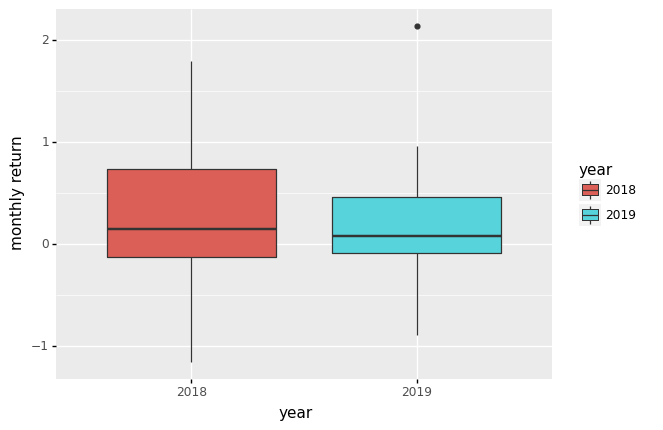

<ggplot: (888268671)>

In [470]:
data = performance.reset_index()
(ggplot(data, aes(x=data["year"].astype("str"), y=data["monthly return"], fill=data["year"].astype("str"))) + 
    geom_boxplot())

In [471]:
market_return = []
previous_ret = 1
for i in range(0, len(performance)):
    previous_ret = previous_ret * (1 +performance["Mkt-RF"].iloc[i])
    market_return.append(previous_ret)
performance["Abnormal Market Return"] = np.array(market_return)


# Get SMH benchmark

smh_benchmark = pd.read_csv("/Users/williamsammartino/Desktop/smh_etf.csv")
smh_benchmark = smh_benchmark[smh_benchmark['TICKER'] == "SMH"]
smh_benchmark["year"] = pd.to_numeric(smh_benchmark['date'].astype('str').str[:4])
smh_benchmark["month"] = pd.to_numeric(smh_benchmark['date'].astype("str").str[4:6])
smh_benchmark.set_index(['year', 'month'], inplace = True)

smh_benchmark['SMH monthly return'] = smh_benchmark["PRC"].pct_change()

performance = performance.merge(smh_benchmark['SMH monthly return'], on=['year', 'month'], how = "left")


smh_return = []
previous_ret = 1
for i in range(0, len(performance)):
    previous_ret = previous_ret * (1 +performance["SMH monthly return"].iloc[i])
    smh_return.append(previous_ret)
performance["SMH Cumulative Return"] = np.array(smh_return)


# Get vix

vix = pd.read_csv("/Users/williamsammartino/Desktop/vix.csv")
vix["date"] = vix["Date"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
vix['Last day of month'] = np.where(vix['date'].dt.is_month_end, 'Yes', 'No')
vix = vix[vix["Last day of month"] == "Yes"]

vix['year'] = pd.DatetimeIndex(vix['date']).year
vix['month'] = pd.DatetimeIndex(vix['date']).month
vix.set_index(['year', 'month'], inplace = True)

vix['VIX monthly return'] = vix["vix"].pct_change()


performance = performance.merge(vix['VIX monthly return'], on=['year', 'month'], how = "left")

performance["VIX monthly return"] = performance["VIX monthly return"].fillna(0)

vix_return = []
previous_ret = 1
for i in range(0, len(performance)):
    previous_ret = previous_ret * (1 +performance["VIX monthly return"].iloc[i])
    vix_return.append(previous_ret)
performance["VIX Cumulative Return"] = np.array(vix_return)

data = performance.reset_index()
data['date'] = data['month'].map(str)+ '-' +data['year'].map(str)
data['date'] = pd.to_datetime(data['date'], format='%m-%Y')

data
data = pd.melt(data, id_vars = ["date"], value_vars = ["ret", "Abnormal Market Return", "SMH Cumulative Return", "VIX Cumulative Return"])
data = data.rename(columns = {"variable" : "Series"})
data.loc[data["Series"] == "ret", "Series"] = "Strategy"
data.loc[data["Series"] == "Abnormal Market Return", "Series"] = "Abnormal Cumulative Market Return"
data.loc[data["Series"] == "SMH Cumulative Return", "Series"] = "SMH Cumulative Return"
data.loc[data["Series"] == "VIX Cumulative Return", "Series"] = "VIX Cumulative Return"

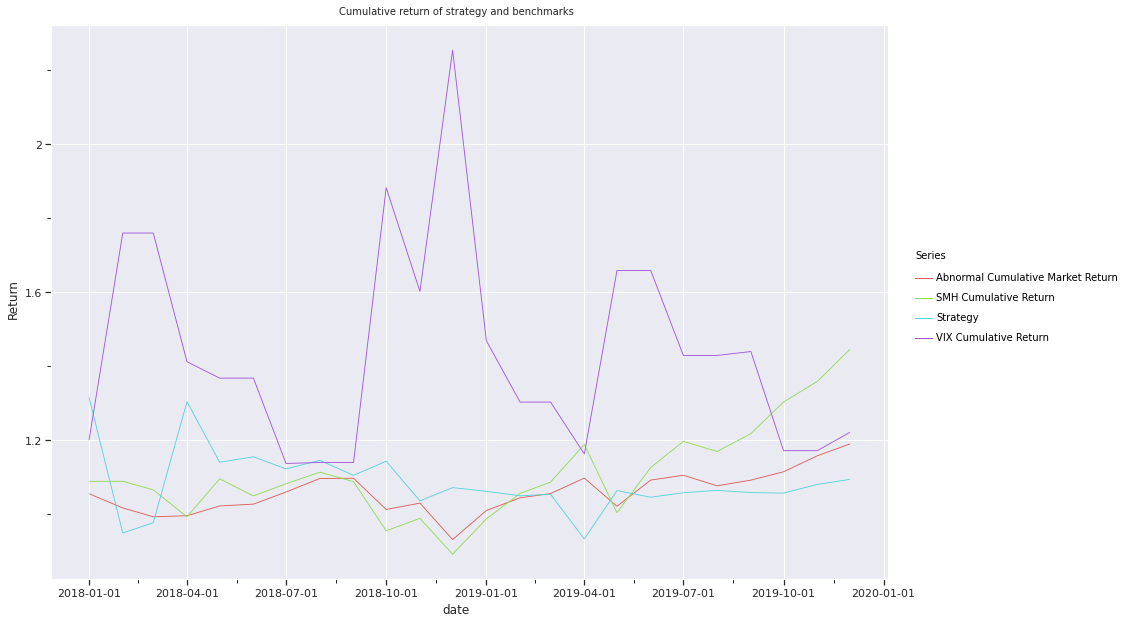

<ggplot: (401269830)>

In [472]:
(ggplot(data = data,  mapping= aes(x = "date", y = "value", color = "Series")) +
 geom_line()+
 theme_bw()+
 theme( element_text(angle = 90, vjust = 0.5, hjust=1)) +
 ylab("Return") +
  ggtitle("Cumulative return of strategy and benchmarks")
)

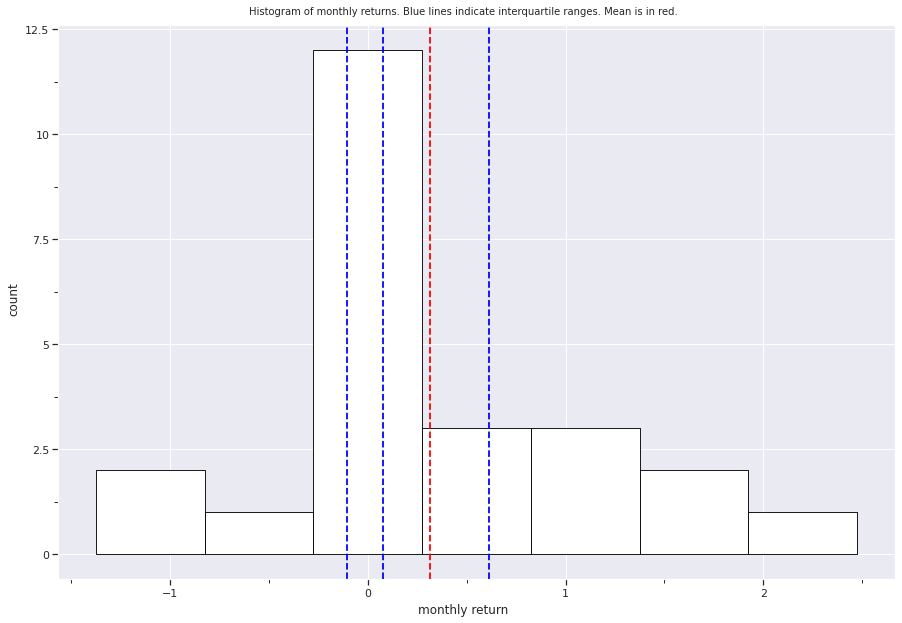

In [475]:
plot_histogram(performance, var = "monthly return", title = "Histogram of monthly returns. Blue lines indicate interquartile ranges. Mean is in red.")

# Optimal Backtesting Parameters

In this section we explore the different parameters that may be used to guide the trading strategy. 



In [498]:
all_performance_summaries['Cone Boundaries'] = all_performance_summaries["high_rank"].astype("str") +"_"+ all_performance_summaries["low_rank"].astype('str')

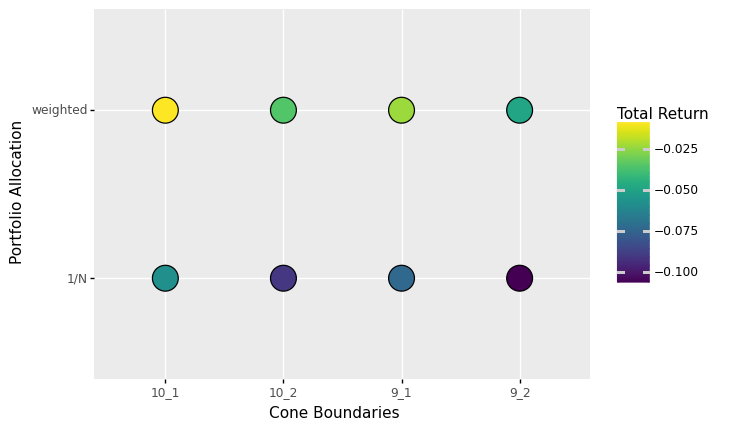

<ggplot: (401412994)>

In [499]:
results_to_plot = all_performance_summaries.groupby(["Portfolio Allocation", "Cone Boundaries"]).mean()


(ggplot(data = results_to_plot.reset_index(), mapping=  aes(y = "Portfolio Allocation", x = "Cone Boundaries")) + 
 geom_point(mapping = aes(fill = "Total Return"), size = 10))

From the plot above, we clearly see that conditional on the cone boundaries, the weighted porfolio allocation scheme delivers better results than the 1/N scheme. 

Which cone boundaries are better? It seems that the 10-1 boundaries are the best as the trading signals they generate are likely to be strongest.

Below we examine risk.

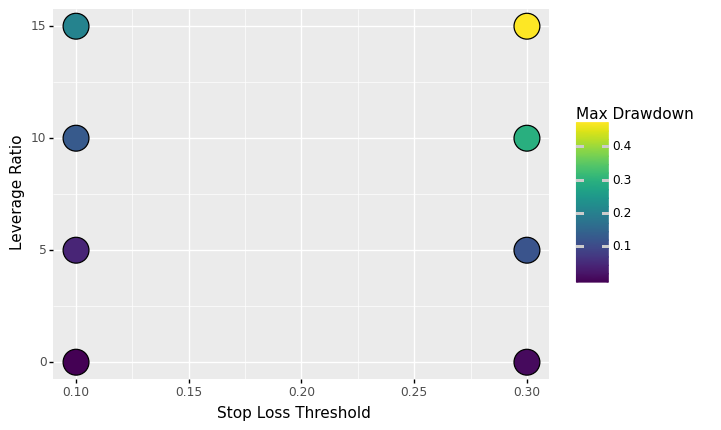

<ggplot: (889661663)>

In [496]:
results_to_plot = all_performance_summaries.groupby(["Leverage Ratio", "Stop Loss Threshold"]).mean()


(ggplot(data = results_to_plot.reset_index(), mapping=  aes(y = "Leverage Ratio", x = "Stop Loss Threshold")) + 
 geom_point(mapping = aes(fill = "Max Drawdown"), size = 10))

From the chart above we see two things at work: 1) as expected, the leverage ratio increases the riskiness of the strategy and increases the maximum drawdown, and 2) a stop loss threshold that is less lenient will be quite successfull in reducing the maximum drawdown for all leverage ratios.

# Conclusion

Overall we see that the parameters have a predictable effect on the strategy. Our optimal strategy has these parameters:

- Cone upper bound quantile = 10
- Cone lower bound quantile = 1
- Realized volatility forecast ahead (days) = 30
- Cone type = Means
- Portfolio allocation = Weighted by expected PnL
- Leverage Ratop = 15
- Stop Loss Threshold (how far can the spot implied volatility go in the wrong direction (%))  = 0.3

We see that the leverage helps us emphasize the profitibality of the vega and our forecasting. The stop loss is there to limit the maximum drawdown, but one might prefer a more restrictive stop loss parameter if 36% is too much. Also, the relatively low Sharpe Ratio is evidence of how volatile the monthly returns are. The graph above shows this. 

That being said our strategy even at its best does underperform Mkt-RF and our benchmark (VanEck Semiconductor ETF (SMH)). However, it shines in terms of how much uncorrelated return it has (alpha = 0.33). This could mean that one could theoretically hedge this strategy with an appropriate exposure to the market, and they would be able to reap the additional return of this strategy. 

In [504]:
performance_summary

,high_rank,low_rank,Portfolio Allocation,Total Spending,Total Return,Stop Loss Threshold,Stop Loss Count,Sharpe Ratio,Information Ratio,Max Drawdown,Total PnL,Alpha,Beta (RF),Beta (Mkt-RF),Beta (SMB),Beta (HML),Downside beta
0,10,1,weighted,5.955160e+06,0.094488,0.3,56,0.396391,0.375258,0.366353,562690.299764,0.336108,32.355775,-10.713076,-0.4741,-1.308426,-31.315271
